## Bibliotecas necessárias

In [2]:
# Importação de Bibliotecas Necessárias
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D,MaxPooling1D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import os
import librosa
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

## Extração de features e download dos sons

In [3]:
dfclass = pd.read_csv(r'UrbanSound8K.csv')
dfclass.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [15]:
FOLDS_PATH = "../urbansound8K/audio"
DURATION = 4 # 4 seconds for each audio file
SAMPLE_RATE = 44100
HOP_LENGTH = round(SAMPLE_RATE * 0.0125)
WIN_LENGTH = round(SAMPLE_RATE * 0.023)
N_FFT = 2**10
TIME_SIZE = 4*SAMPLE_RATE//HOP_LENGTH+1

In [7]:
def load_fold_data(features_file, labels_file, label_encoder):
    features = pd.read_csv(features_file).values
    labels = pd.read_csv(labels_file)['0']
    encoded_labels = label_encoder.transform(labels)
    return features, encoded_labels

In [8]:
def create_label_mapping(folds_path, n_folds):
    all_labels = set()
    for fold_number in range(1, n_folds + 1):
        labels_file = f'../csv/labels_fold{fold_number}.csv'
        df_labels = pd.read_csv(labels_file)
        all_labels.update(df_labels['0'].unique())
    
    label_encoder = LabelEncoder()
    label_encoder.fit(list(all_labels))
    return label_encoder


In [16]:
import os
import librosa
import numpy as np
import pandas as pd

def load_data():
    for fold in range(1, 11):
        features = []
        labels = []
        fold_path = os.path.join(FOLDS_PATH, f'fold{fold}')
        print(fold_path)
        audio_files = librosa.util.find_files(fold_path)
        print(audio_files)

        for audio_file_path in audio_files:
            # Carregar o arquivo de áudio
            audio_data, sample_rate = librosa.load(audio_file_path)
            audio_data = librosa.util.fix_length(audio_data, size=int(4 * SAMPLE_RATE))
            
            mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            
            chroma = librosa.feature.chroma_stft(y=audio_data, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
            mfccs_mean = np.mean(mfccs.T, axis=0)  # Média dos MFCCs ao longo do tempo

            # Combinar as características

            # Adicionar características à lista
            features.append(mfccs_mean)
            features.append(mel_spec)
            features.append(chroma)

            # Obter rótulo para o arquivo de áudio
            audio_file = os.path.basename(audio_file_path)
            label = dfclass.loc[dfclass['slice_file_name'] == audio_file, 'class'].iloc[0]
            labels.append(label)

        # Salvar características e rótulos em CSV
        features_df = pd.DataFrame(features)
        features_df.to_csv(f'../csv/features_fold{fold}.csv', index=False)
        labels_df = pd.DataFrame(labels)
        labels_df.to_csv(f'../csv/labels_fold{fold}.csv', index=False)
        print(f"Fold {fold} processado e salvo.")
load_data()

../urbansound8K/audio/fold1
['/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/101415-3-0-2.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/101415-3-0-3.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/101415-3-0-8.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/102106-3-0-0.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/102305-6-0-0.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/102842-3-0-1.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/102842-3-1-0.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/102842-3-1-5.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/102842-3-1-6.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/103074-7-0-0.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/103074-7-0-1.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/103074-7-0-2.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/103074-7-1-0.wav', '/home/campiao/LIACD/AC2/urbansound8K/audio/fold1/103074-7-1-1.wav', '/hom

## Vamos observar cada fold em particular

In [17]:
def analyze_fold(fold_number):
    # Carregar características e rótulos do fold específico
    features_path = f"../csv/features_fold{fold_number}.csv"
    labels_path = f"../csv/labels_fold{fold_number}.csv"
    df_labels = pd.read_csv(labels_path)

    # Adicionar os rótulos ao DataFrame das características
    

    # Observar rótulos únicos
    unique_labels = df_labels['0'].unique()
    print(f"Etiquetas únicas no conjunto de dados do fold {fold_number}: {unique_labels}\n")

for i in range(1,11):
    analyze_fold(i)

Etiquetas únicas no conjunto de dados do fold 1: ['dog_bark' 'gun_shot' 'jackhammer' 'engine_idling' 'children_playing'
 'siren' 'street_music' 'air_conditioner' 'drilling' 'car_horn']

Etiquetas únicas no conjunto de dados do fold 2: ['dog_bark' 'engine_idling' 'siren' 'drilling' 'children_playing'
 'air_conditioner' 'car_horn' 'street_music' 'gun_shot' 'jackhammer']

Etiquetas únicas no conjunto de dados do fold 3: ['dog_bark' 'drilling' 'engine_idling' 'gun_shot' 'car_horn' 'siren'
 'children_playing' 'air_conditioner' 'street_music' 'jackhammer']

Etiquetas únicas no conjunto de dados do fold 4: ['dog_bark' 'street_music' 'jackhammer' 'siren' 'car_horn' 'engine_idling'
 'drilling' 'gun_shot' 'children_playing' 'air_conditioner']

Etiquetas únicas no conjunto de dados do fold 5: ['dog_bark' 'children_playing' 'air_conditioner' 'jackhammer'
 'street_music' 'engine_idling' 'siren' 'drilling' 'car_horn' 'gun_shot']

Etiquetas únicas no conjunto de dados do fold 6: ['dog_bark' 'children

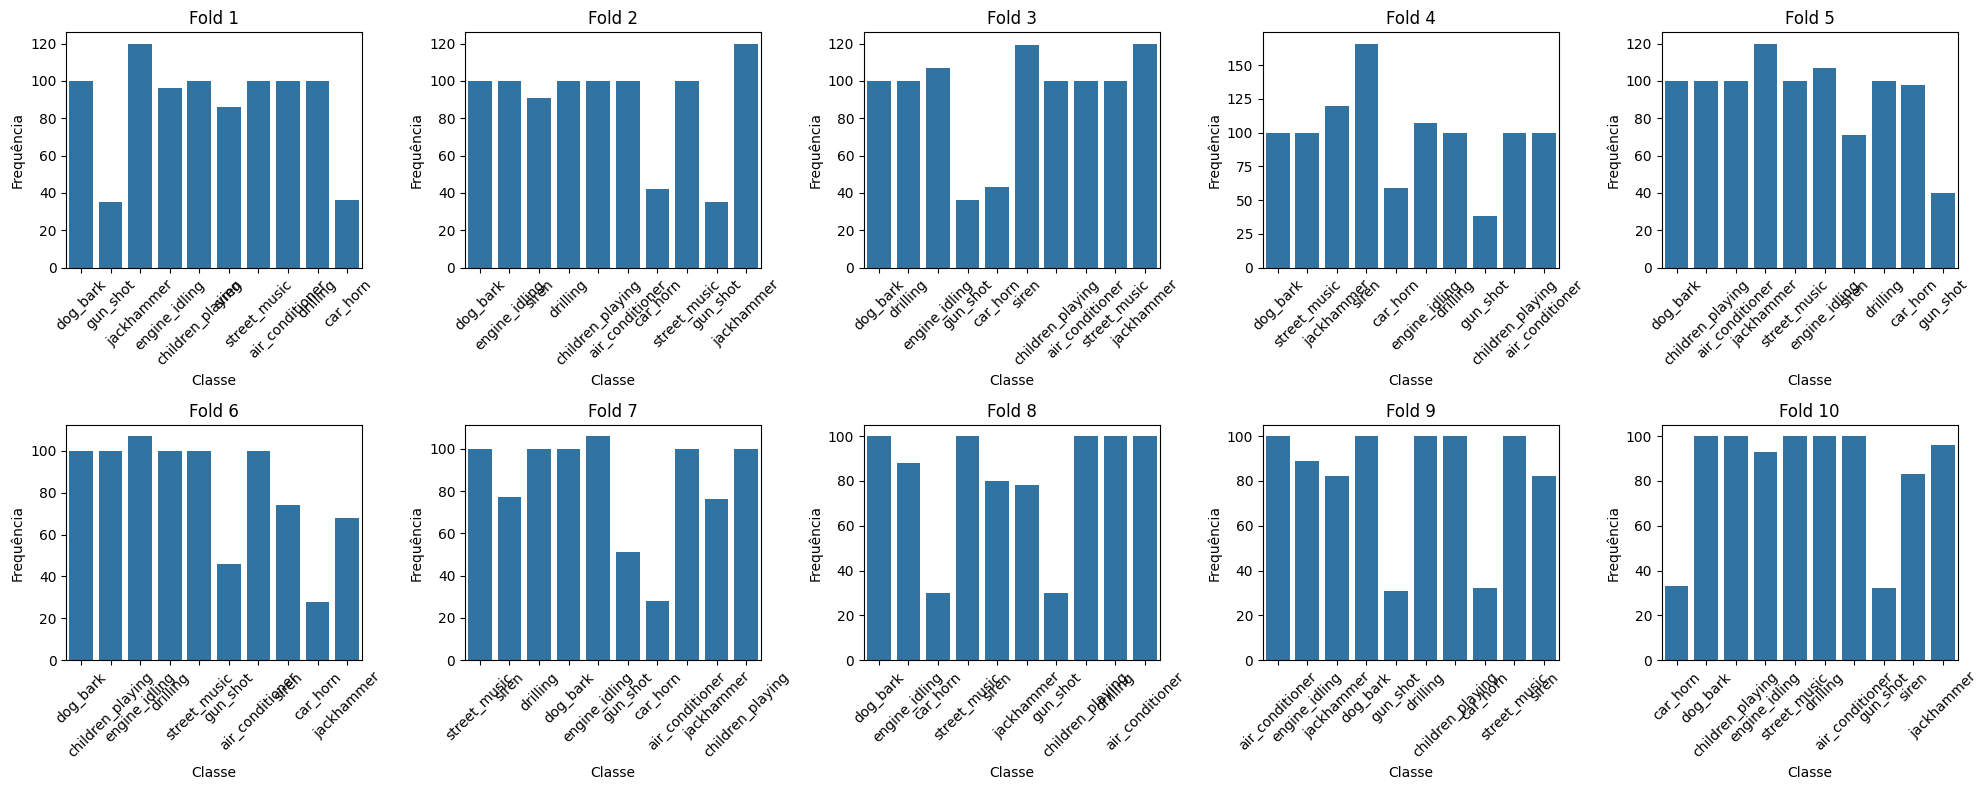

In [18]:
def plot_label_distribution_all_folds(n_folds):
    # Número de linhas e colunas para os subplots
    nrows = 2
    ncols = 5

    # Configurar o layout para os subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))  # Ajuste o tamanho conforme necessário

    for fold_number in range(1, n_folds + 1):
        # Carregar os rótulos do fold específico
        labels_path = f"../csv/labels_fold{fold_number}.csv"
        df_labels = pd.read_csv(labels_path)

        # Determinar a posição do subplot
        row = (fold_number - 1) // ncols
        col = (fold_number - 1) % ncols

        # Plotar o gráfico no subplot correspondente
        sns.countplot(x=df_labels['0'], ax=axes[row, col])
        axes[row, col].set_title(f'Fold {fold_number}')
        axes[row, col].set_xlabel('Classe')
        axes[row, col].set_ylabel('Frequência')
        axes[row, col].tick_params(axis='x', rotation=45)

    # Ajustar o layout e exibir a figura
    plt.tight_layout()
    plt.show()

# Exemplo de uso para todos os 10 folds
plot_label_distribution_all_folds(10)

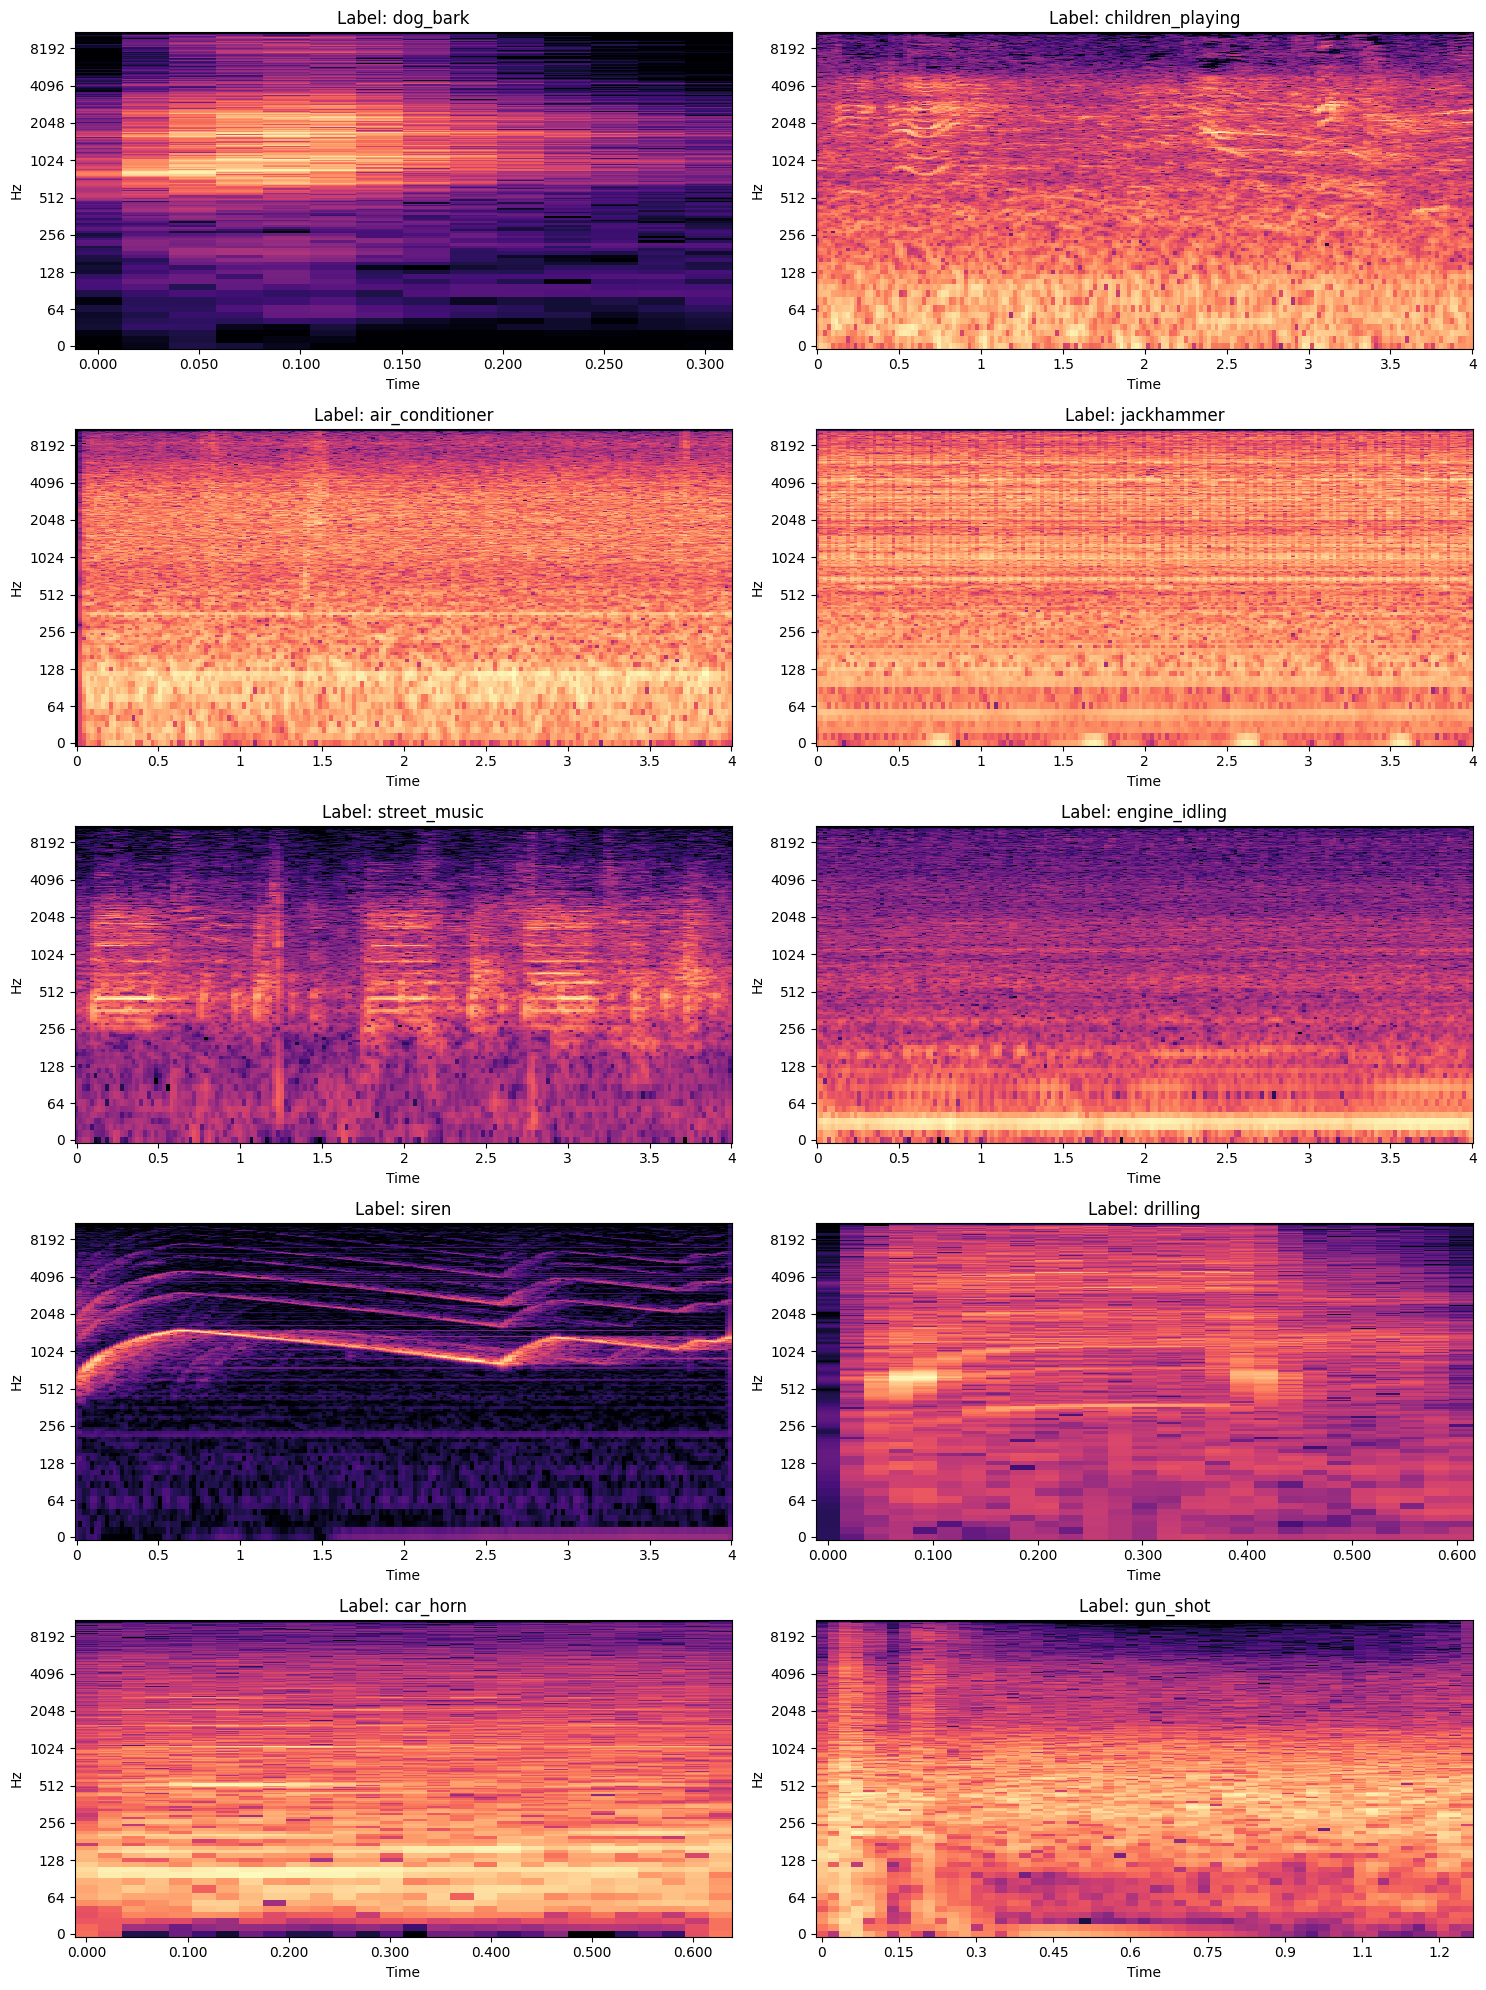

In [19]:
# Preparando o layout para os subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))  #tamanho dos subplots
axes = axes.flatten()  # array unidimensional
processed_labels = set()
label_count = 0

folds = [fold for fold in os.listdir(FOLDS_PATH) if "fold" in fold]
for fold in folds:
    audio_files = librosa.util.find_files(FOLDS_PATH+"/"+fold)
    features = []
    labels = []
    for audio_file_path in audio_files:

        # Carregar o arquivo de áudio
        audio_data, sample_rate = librosa.load(audio_file_path)
        audio_file = audio_file_path.split("/")[-1]
        label=dfclass.loc[dfclass['slice_file_name'] == audio_file, 'class'].iloc[0]

        if label not in processed_labels:
            processed_labels.add(label)

            # Meter grafico no subplot correspondente
            librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max), 
                                     sr=sample_rate, 
                                     x_axis='time', 
                                     y_axis='log', 
                                     ax=axes[label_count])
            axes[label_count].set_title(f'Label: {label}') 
            label_count += 1
            if label_count >= 10:  # Se já tiver os 10 graficos
                break

plt.tight_layout()
plt.show()

## K-Fold Cross Validation

### Para a CNN

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
def kfoldcnn(n_folds, label_encoder):
    accuracies = []
    conf_matrices = []
    all_histories = []
    scaler = StandardScaler()

    for test_fold in range(1, n_folds + 1):
        X_train, y_train = [], []
        for fold in range(1, n_folds + 1):
            model=createmodel()
            features_file = f'../csv/features_fold{fold}.csv'
            labels_file = f'../csv/labels_fold{fold}.csv'
            features, encoded_labels = load_fold_data(features_file, labels_file, label_encoder)

            if fold == test_fold:
                X_test, y_test = features, encoded_labels
            else:
                X_train.append(features)
                y_train.append(encoded_labels)

        # Concatenar e preparar os dados de treino
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        
        print("ai")
        # Dividir o conjunto de teste em validação e teste
        X_val, X_test_final, y_val, y_test_final = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
        print("ai")
        
        # Normalizar os dados
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.fit_transform(X_val)
        X_test_final = scaler.fit_transform(X_test_final)

        # Conversão para formato categórico
        y_train_categorical = to_categorical(y_train)
        y_val_categorical = to_categorical(y_val)
        y_test_final_categorical = to_categorical(y_test_final)

        # Construir, compilar e treinar o modelo
        print(X_train.shape)
        print(X_val.shape)
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        hist = model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_val, y_val_categorical))
        all_histories.append(hist.history)

        # Avaliação do modelo no conjunto de teste final
        test_loss, test_accuracy = model.evaluate(X_test_final, y_test_final_categorical)
        accuracies.append(test_accuracy)

        # Previsão e matriz de confusão
        y_pred = model.predict(X_test_final)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_final_categorical, axis=1)
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
        conf_matrices.append(conf_mat)

    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print("Matriz de Confusão Média:\n", mean_conf_matrix)
    print(f"Acurácia média: {mean_accuracy:.2f}, Desvio padrão: {std_accuracy:.2f}")

    return all_histories, mean_conf_matrix, mean_accuracy, std_accuracy


### Para o MLP

In [21]:
def kfoldmlp(n_folds, label_encoder, num_classes):
    accuracies = []
    conf_matrices = []
    all_histories = []
    scaler = StandardScaler()

    for test_fold in range(1, n_folds + 1):
        X_train, y_train = [], []
        for fold in range(1, n_folds + 1):
            features_file = f'../csv/features_fold{fold}.csv'
            labels_file = f'../csv/labels_fold{fold}.csv'
            features, encoded_labels = load_fold_data(features_file, labels_file, label_encoder)

            if fold == test_fold:
                X_test, y_test = features, encoded_labels
            else:
                X_train.append(features)
                y_train.append(encoded_labels)

        # Concatenar e preparar os dados de treino
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))

        # Normalizar os dados
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Conversão para formato categórico
        y_train_categorical = to_categorical(y_train, num_classes=num_classes)
        y_test_categorical = to_categorical(y_test, num_classes=num_classes)

        # Construir, compilar e treinar o modelo
        hist = modelMLP.fit(X_train, y_train_categorical, epochs=5, batch_size=64, validation_data=(X_test, y_test_categorical), verbose=0)
        all_histories.append(hist.history)

        # Avaliação do modelo
        test_loss, test_accuracy = modelMLP.evaluate(X_test, y_test_categorical)
        y_pred = modelMLP.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_categorical, axis=1)
        
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
        conf_matrices.append(conf_mat)
        accuracies.append(test_accuracy)

    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print("Matriz de Confusão Média:\n", mean_conf_matrix)
    print(f"Acurácia média: {mean_accuracy:.2f}, Desvio padrão: {std_accuracy:.2f}")

    return all_histories, mean_conf_matrix, mean_accuracy, std_accuracy


## Primeiro Modelo Convulsional Neural Network

### Definir a arquitetura:

##### Camadas Conv1D: Duas camadas convolucionais com 64 e 128 filtros, respectivamente, e kernels de tamanho 3. Essas camadas são responsáveis por extrair características relevantes dos dados de áudio.

##### Camadas MaxPooling1D: Seguindo cada camada convolucional, estas camadas reduzem a dimensionalidade dos dados, o que ajuda a diminuir a complexidade computacional e a combater o overfitting.

##### Camada Flatten: Transforma os dados de uma forma multidimensional para um vetor unidimensional, preparando-os para a próxima etapa de processamento.

##### Camada Densa e Dropout: Uma camada densa com 128 neurônios é seguida por uma camada de dropout que ajuda a prevenir o overfitting ao descartar aleatoriamente parte dos sinais.

##### Camada de Saída: Uma camada densa com uma função de ativação 'softmax', utilizada para a classificação multiclasse. O número de neurônios nesta camada corresponde ao número de classes a serem previstas.

### Compilação do Modelo

##### O modelo é compilado com o otimizador 'adam' e a função de perda 'categorical_crossentropy', com 'accuracy' como métrica de desempenho. Este setup é padrão para problemas de classificação multiclasse.

In [22]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


def createmodel():
    model = Sequential()
    model.add(Conv1D(16, 3, activation='relu', input_shape=(407,1), kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(3))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model




In [23]:
import keras
keras.utils.plot_model(model, 'CNN.png', show_shapes=True)

NameError: name 'model' is not defined

### K-Fold Cross Validation com os folds predefenidos 

In [24]:
n_folds = 10
accuracies = []
conf_matrices = []
all_histories = []

label_encoder = create_label_mapping(FOLDS_PATH, n_folds)

all_histories, mean_conf_matrix, mean_accuracy, std_accuracy=kfoldcnn(10,label_encoder)

ai


ValueError: Found input variables with inconsistent numbers of samples: [2619, 873]

In [7]:
average_history = {
    'loss': np.mean([x['loss'] for x in all_histories], axis=0),
    'accuracy': np.mean([x['accuracy'] for x in all_histories], axis=0),
    'val_loss': np.mean([x['val_loss'] for x in all_histories], axis=0),
    'val_accuracy': np.mean([x['val_accuracy'] for x in all_histories], axis=0),
}

print(len(average_history['val_accuracy']))

# Plotar os gráficos
epochs = range(1, 6)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, average_history['loss'], 'co', label='Training Loss')
ax1.plot(epochs, average_history['val_loss'], 'm', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, average_history['accuracy'], 'co', label='Training Accuracy')
ax2.plot(epochs, average_history['val_accuracy'], 'm', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

NameError: name 'all_histories' is not defined

## Segundo Modelo: Multi-Layer Perceptron

In [25]:
modelMLP = Sequential()
modelMLP.add(Dense(256, activation='relu', input_shape=(407,1)))
modelMLP.add(Dropout(0.1))
modelMLP.add(Dense(128, activation='relu'))
modelMLP.add(Dropout(0.1))
modelMLP.add(Dense(10, activation='softmax'))

modelMLP.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

modelMLP.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 407, 256)          512       
                                                                 
 dropout_10 (Dropout)        (None, 407, 256)          0         
                                                                 
 dense_21 (Dense)            (None, 407, 128)          32896     
                                                                 
 dropout_11 (Dropout)        (None, 407, 128)          0         
                                                                 
 dense_22 (Dense)            (None, 407, 10)           1290      
                                                                 
Total params: 34698 (135.54 KB)
Trainable params: 34698 (135.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


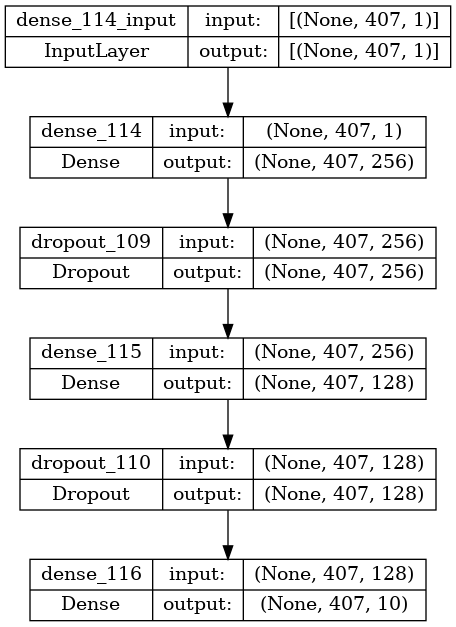

In [384]:
keras.utils.plot_model(modelMLP, 'MLP.png', show_shapes=True)

In [26]:
n_folds = 10
accuracies = []
conf_matrices = []
all_histories = []

label_encoder = create_label_mapping(FOLDS_PATH, n_folds)
all_histories, mean_conf_matrix, mean_accuracy, std_accuracy=kfoldmlp(n_folds, label_encoder, 10)

ValueError: could not convert string to float: '[-80.       -54.790897 -38.45891  -44.847157 -47.78651  -32.055782\n -37.53722  -45.679905 -34.72985  -33.10828  -39.998123 -35.151997\n -27.21652  -36.04883  -27.985874 -25.69136  -28.265133 -37.658825\n -37.33177  -33.57255  -32.216602 -38.081894 -31.069347 -33.936676\n -38.01351  -36.83072  -40.846413 -39.112896 -39.70563  -37.705994\n -47.130722 -33.242374 -36.038277 -37.44417  -46.937485 -37.01556\n -29.782726 -27.377432 -47.585175 -40.75284  -42.1746   -30.742718\n -36.13738  -35.529034 -36.133816 -41.022377 -40.90445  -41.480164\n -35.07097  -34.851334 -34.494278 -37.490215 -31.229647 -43.215363\n -39.753178 -46.20302  -40.92682  -42.96788  -48.14669  -44.937798\n -44.700066 -46.417904 -46.143715 -51.00648  -57.11514  -52.773506\n -39.10004  -40.947044 -44.44937  -39.345272 -44.280563 -40.29737\n -42.50572  -40.469578 -53.061745 -40.007977 -39.641068 -43.348\n -49.06701  -34.9676   -49.41436  -42.606895 -42.243683 -54.88745\n -62.058174 -66.73723  -68.560486 -52.209305 -50.74357  -47.84201\n -52.741096 -57.08932  -62.002975 -52.10141  -54.975487 -58.292847\n -47.936577 -50.110878 -48.83567  -52.259827 -51.678722 -48.23999\n -45.272762 -50.827534 -41.71881  -41.413387 -68.367935 -53.51449\n -52.66098  -54.88501  -56.723663 -72.12778  -55.93627  -46.75394\n -34.807446 -56.926495 -29.274254 -35.362568 -48.54725  -43.911243\n -56.4429   -39.674446 -45.89263  -50.111977 -46.089798 -43.340755\n -51.604527 -65.021324 -48.45923  -58.073788 -49.915245 -49.26165\n -50.001606 -51.614056 -57.687447 -50.125    -51.901703 -56.318855\n -52.850468 -50.788147 -57.523964 -57.06924  -50.467777 -62.958443\n -59.625893 -53.837605 -52.613766 -55.181313 -56.497673 -65.64333\n -57.594055 -58.27653  -53.410664 -47.571133 -59.838924 -48.355614\n -50.97557  -61.559155 -52.651318 -54.51187  -51.24512 ]'

In [ ]:
average_history = {
    'loss': np.mean([x['loss'] for x in all_histories], axis=0),
    'accuracy': np.mean([x['accuracy'] for x in all_histories], axis=0),
    'val_loss': np.mean([x['val_loss'] for x in all_histories], axis=0),
    'val_accuracy': np.mean([x['val_accuracy'] for x in all_histories], axis=0),
}


# Plotar os gráficos
epochs = range(1, 26)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, average_history['loss'], 'co', label='Training Loss')
ax1.plot(epochs, average_history['val_loss'], 'm', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, average_history['accuracy'], 'co', label='Training Accuracy')
ax2.plot(epochs, average_history['val_accuracy'], 'm', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()